In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical


In [3]:
import pandas as pd

# Load the  datasets
df_main = pd.read_csv('Final_Enriched_IDS_Dataset.csv')
df_lsb = pd.read_csv('LSB_Exfiltration_Only_Dataset.csv')

# Merge both datasets
df_merged = pd.concat([df_main, df_lsb], ignore_index=True)

# Assign the merged dataset back to df
df = df_merged

# Save the merged dataset with the same name
df.to_csv('Final_Enriched_IDS_Dataset.csv', index=False)

# Confirm merge and attack type distribution
print(" Merged and saved as Final_Enriched_IDS_Dataset.csv")
print("Merged Shape:", df.shape)
print("Attack Type Distribution:\n", df['attack_type'].value_counts())


 Merged and saved as Final_Enriched_IDS_Dataset.csv
Merged Shape: (13499884, 10)
Attack Type Distribution:
 attack_type
Least Significant Bit exfiltration    13411496
Normal                                   58325
Characterization                         12296
Send fake command                        11166
Moving Two files                          3319
Exploit ms08 netapi                       1856
CnC uploading exe                         1426
Name: count, dtype: int64


In [4]:
# Overview of data types and nulls
df.info()

# Count nulls in each column
print("\nMissing values per column:")
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13499884 entries, 0 to 13499883
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Time            float64
 1   Source          object 
 2   Destination     object 
 3   Protocol        object 
 4   Length          int64  
 5   Info            object 
 6   query_type      object 
 7   function_code   float64
 8   transaction_id  float64
 9   attack_type     object 
dtypes: float64(3), int64(1), object(6)
memory usage: 1.0+ GB

Missing values per column:
Time                    0
Source                  0
Destination             0
Protocol                0
Length                  0
Info                    0
query_type        8808462
function_code     8808613
transaction_id    8808613
attack_type             0
dtype: int64


In [5]:
print("\nAttack types BEFORE cleaning:")
print(df['attack_type'].value_counts())



Attack types BEFORE cleaning:
attack_type
Least Significant Bit exfiltration    13411496
Normal                                   58325
Characterization                         12296
Send fake command                        11166
Moving Two files                          3319
Exploit ms08 netapi                       1856
CnC uploading exe                         1426
Name: count, dtype: int64


Attack type distribution:
 attack_type
Least Significant Bit exfiltration    13411496
Normal                                   58325
Characterization                         12296
Send fake command                        11166
Moving Two files                          3319
Exploit ms08 netapi                       1856
CnC uploading exe                         1426
Name: count, dtype: int64


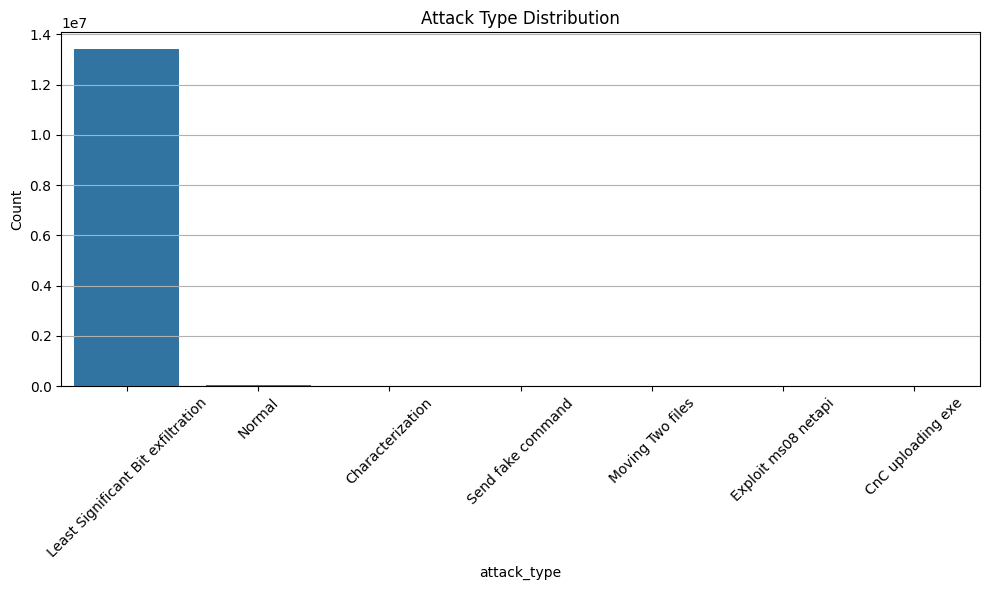

In [6]:
# Count each attack type and visualize
attack_counts = df['attack_type'].value_counts()
print("Attack type distribution:\n", attack_counts)

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(x=attack_counts.index, y=attack_counts.values)
plt.title('Attack Type Distribution')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [7]:
# Drop rows without function code — not useful for model training
df_clean = df.dropna(subset=['function_code'])

print("Shape after dropping non-Modbus packets:", df_clean.shape)

# Show updated class distribution
print("\nAttack type distribution (cleaned):")
print(df_clean['attack_type'].value_counts())


Shape after dropping non-Modbus packets: (4691271, 10)

Attack type distribution (cleaned):
attack_type
Least Significant Bit exfiltration    4666880
Normal                                  12852
Characterization                         7919
Send fake command                        2466
Moving Two files                          720
CnC uploading exe                         290
Exploit ms08 netapi                       144
Name: count, dtype: int64


In [8]:
# Encode categorical features
from sklearn.preprocessing import LabelEncoder

df_clean['query_type'] = df_clean['query_type'].fillna('Unknown')
df_clean['Protocol'] = df_clean['Protocol'].fillna('Unknown')

# Encode query_type and protocol using one-hot
df_encoded = pd.get_dummies(df_clean, columns=['query_type', 'Protocol'])

# Label encode the target
label_encoder = LabelEncoder()
df_encoded['attack_label'] = label_encoder.fit_transform(df_encoded['attack_type'])

# Save the mapping
attack_label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nAttack Label Mapping:")
print(attack_label_mapping)


C:\Users\CRAIB_LAB\AppData\Local\Temp\ipykernel_4844\2497952947.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['query_type'] = df_clean['query_type'].fillna('Unknown')
C:\Users\CRAIB_LAB\AppData\Local\Temp\ipykernel_4844\2497952947.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Protocol'] = df_clean['Protocol'].fillna('Unknown')



Attack Label Mapping:
{'Characterization': np.int64(0), 'CnC uploading exe': np.int64(1), 'Exploit ms08 netapi': np.int64(2), 'Least Significant Bit exfiltration': np.int64(3), 'Moving Two files': np.int64(4), 'Normal': np.int64(5), 'Send fake command': np.int64(6)}


In [9]:
# Define features and label
feature_cols = ['Time', 'Length', 'function_code', 'transaction_id'] + \
               [col for col in df_encoded.columns if col.startswith('query_type_') or col.startswith('Protocol_')]

X = df_encoded[feature_cols]
y = df_encoded['attack_label']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [10]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Reshape for CNN: (samples, features, 1)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Convert y to categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

print("CNN input shape:", X_train_cnn.shape)


CNN input shape: (3753016, 7, 1)


In [20]:
import pandas as pd
import numpy as np

# Save X_test_cnn (reshaped) and y_test_cat (categorical labels) to CSV so that we may use it in part2 
np.savetxt("X_test_cnn.csv", X_test_cnn.reshape(X_test_cnn.shape[0], -1), delimiter=",")
np.savetxt("y_test_cat.csv", y_test_cat, delimiter=",")

print("Test data saved as CSV files!")


Test data saved as CSV files!


In [11]:
input_shape = X_train_cnn.shape[1:]

model = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(128, kernel_size=2, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\CRAIB_LAB\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 6, 64)               │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 6, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 5, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,951 (230.28 KB)

 Trainable params: 58,567 (228.78 KB)

 Non-trainable params: 384 (1.50 KB)

In [12]:
from sklearn.utils import class_weight

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dict for Keras
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)


Class Weights: {0: np.float64(84.6322246025482), 1: np.float64(2310.9704433497536), 2: np.float64(4662.131677018633), 3: np.float64(0.14360377984352574), 4: np.float64(930.8075396825396), 5: np.float64(52.14405201878456), 6: np.float64(271.74107595394975)}


In [13]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_cnn, y_train_cat,
    validation_split=0.2,
    epochs=28,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)


Epoch 1/28
46913/46913 ━━━━━━━━━━━━━━━━━━━━ 200s 4ms/step - accuracy: 0.7870 - loss: 2.1076 - val_accuracy: 0.8663 - val_loss: 0.4919
Epoch 2/28
46913/46913 ━━━━━━━━━━━━━━━━━━━━ 200s 4ms/step - accuracy: 0.8557 - loss: 1.7341 - val_accuracy: 0.7437 - val_loss: 0.8724
Epoch 3/28
46913/46913 ━━━━━━━━━━━━━━━━━━━━ 196s 4ms/step - accuracy: 0.8218 - loss: 1.6720 - val_accuracy: 0.8694 - val_loss: 0.5628
Epoch 4/28
46913/46913 ━━━━━━━━━━━━━━━━━━━━ 190s 4ms/step - accuracy: 0.8222 - loss: 1.8109 - val_accuracy: 0.5880 - val_loss: 1.7154
Epoch 5/28
46913/46913 ━━━━━━━━━━━━━━━━━━━━ 203s 4ms/step - accuracy: 0.8228 - loss: 1.7947 - val_accuracy: 0.8562 - val_loss: 0.7736
Epoch 6/28
46913/46913 ━━━━━━━━━━━━━━━━━━━━ 220s 5ms/step - accuracy: 0.8159 - loss: 1.9136 - val_accuracy: 0.8150 - val_loss: 1.1427


Test Accuracy: 0.8659
29321/29321 ━━━━━━━━━━━━━━━━━━━━ 43s 1ms/step

Classification Report:
                                    precision    recall  f1-score   support

                  Characterization       1.00      0.84      0.91      1584
                 CnC uploading exe       0.00      0.41      0.00        58
               Exploit ms08 netapi       0.00      0.66      0.00        29
Least Significant Bit exfiltration       1.00      0.87      0.93    933377
                  Moving Two files       0.00      0.24      0.00       144
                            Normal       0.13      0.77      0.22      2570
                 Send fake command       0.01      0.45      0.01       493

                          accuracy                           0.87    938255
                         macro avg       0.31      0.60      0.30    938255
                      weighted avg       1.00      0.87      0.93    938255



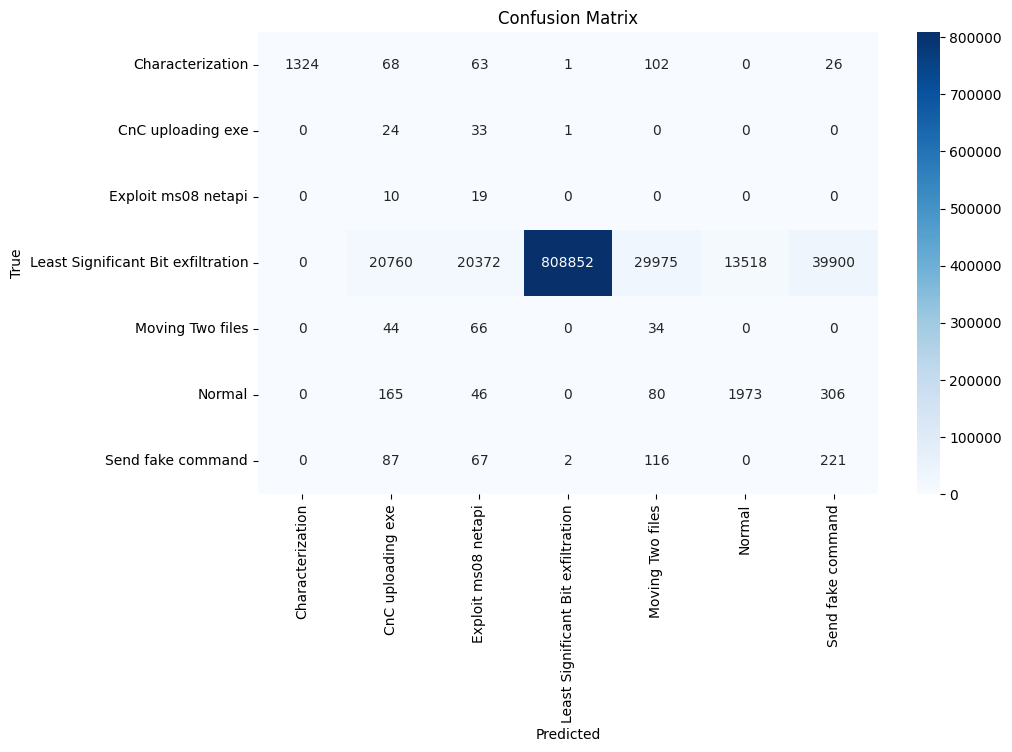

In [14]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test_cnn, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict & evaluate
y_pred_probs = model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


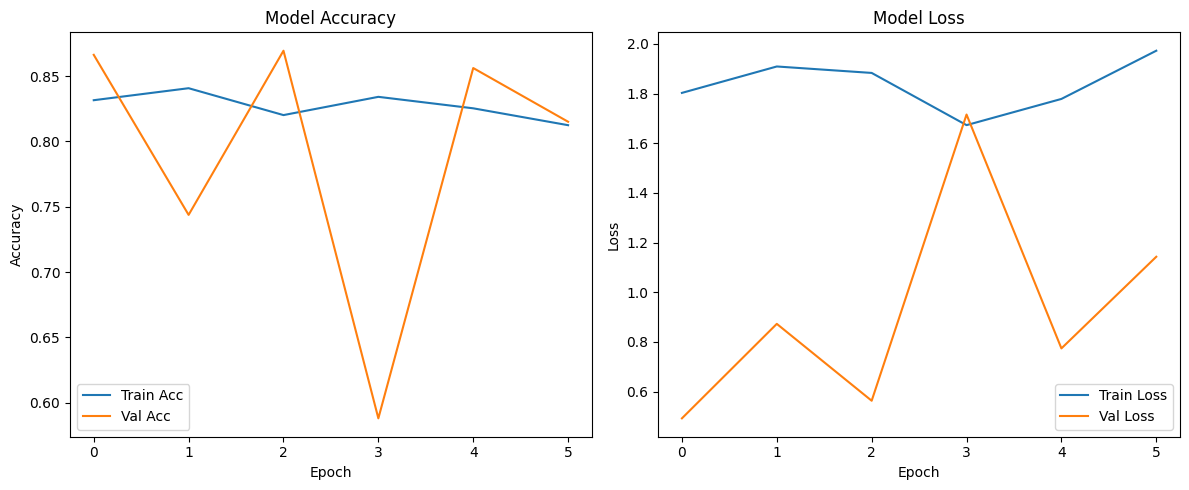

In [15]:
# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
model.save('IDS1_model.h5') 

In [17]:
#Trying to improve the model Performance/ Accuracy
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight

# Assuming X_train_cnn, y_train_cat are prepared and class_weight_dict is defined

# Compute class weights to handle imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dictionary for Keras
class_weight_dict = dict(enumerate(class_weights))

# Model architecture with regularization, dropout, and more layers
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1), 
           kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),  # Increased dropout rate to reduce overfitting

    Conv1D(128, kernel_size=3, activation='relu', 
           kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),  # Increased dropout rate

    Conv1D(256, kernel_size=3, activation='relu', 
           kernel_regularizer=regularizers.l2(0.01)),  # Adding more depth to the model
    BatchNormalization(),
    Dropout(0.5),  # Increased dropout rate

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Increased dropout rate
    Dense(y_train_cat.shape[1], activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)  # Lower learning rate to fine-tune
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate on plateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model with early stopping and learning rate reduction
history = model.fit(
    X_train_cnn, y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    class_weight=class_weight_dict,  # Class weight to handle class imbalance
    callbacks=[early_stop, lr_scheduler]  # Early stopping + learning rate scheduler
)


C:\Users\CRAIB_LAB\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
46913/46913 ━━━━━━━━━━━━━━━━━━━━ 260s 5ms/step - accuracy: 0.4944 - loss: 4.7584 - val_accuracy: 0.7508 - val_loss: 2.1895 - learning_rate: 1.0000e-04
Epoch 2/50
46913/46913 ━━━━━━━━━━━━━━━━━━━━ 250s 5ms/step - accuracy: 0.7526 - loss: 2.8276 - val_accuracy: 0.7803 - val_loss: 1.6853 - learning_rate: 1.0000e-04
Epoch 3/50
46913/46913 ━━━━━━━━━━━━━━━━━━━━ 254s 5ms/step - accuracy: 0.7790 - loss: 2.4570 - val_accuracy: 0.7888 - val_loss: 1.4051 - learning_rate: 1.0000e-04
Epoch 4/50
46913/46913 ━━━━━━━━━━━━━━━━━━━━ 252s 5ms/step - accuracy: 0.7872 - loss: 2.1915 - val_accuracy: 0.8062 - val_loss: 1.3146 - learning_rate: 1.0000e-04
Epoch 5/50
46913/46913 ━━━━━━━━━━━━━━━━━━━━ 252s 5ms/step - accuracy: 0.8003 - loss: 2.0589 - val_accuracy: 0.8113 - val_loss: 1.2410 - learning_rate: 1.0000e-04
Epoch 6/50
46913/46913 ━━━━━━━━━━━━━━━━━━━━ 255s 5ms/step - accuracy: 0.7997 - loss: 2.0778 - val_accuracy: 0.7814 - val_loss: 1.5538 - learning_rate: 1.0000e-04
Epoch 7/50
46913/46913 ━━━━━

29321/29321 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step
Classification Report:
                                     precision    recall  f1-score   support

                  Characterization       0.60      0.84      0.70      1584
                 CnC uploading exe       0.01      0.47      0.02        58
               Exploit ms08 netapi       0.01      1.00      0.01        29
Least Significant Bit exfiltration       1.00      0.93      0.97    933377
                  Moving Two files       0.01      1.00      0.01       144
                            Normal       0.28      0.94      0.43      2570
                 Send fake command       0.02      0.92      0.03       493

                          accuracy                           0.93    938255
                         macro avg       0.27      0.87      0.31    938255
                      weighted avg       1.00      0.93      0.96    938255

Test Accuracy: 0.9329


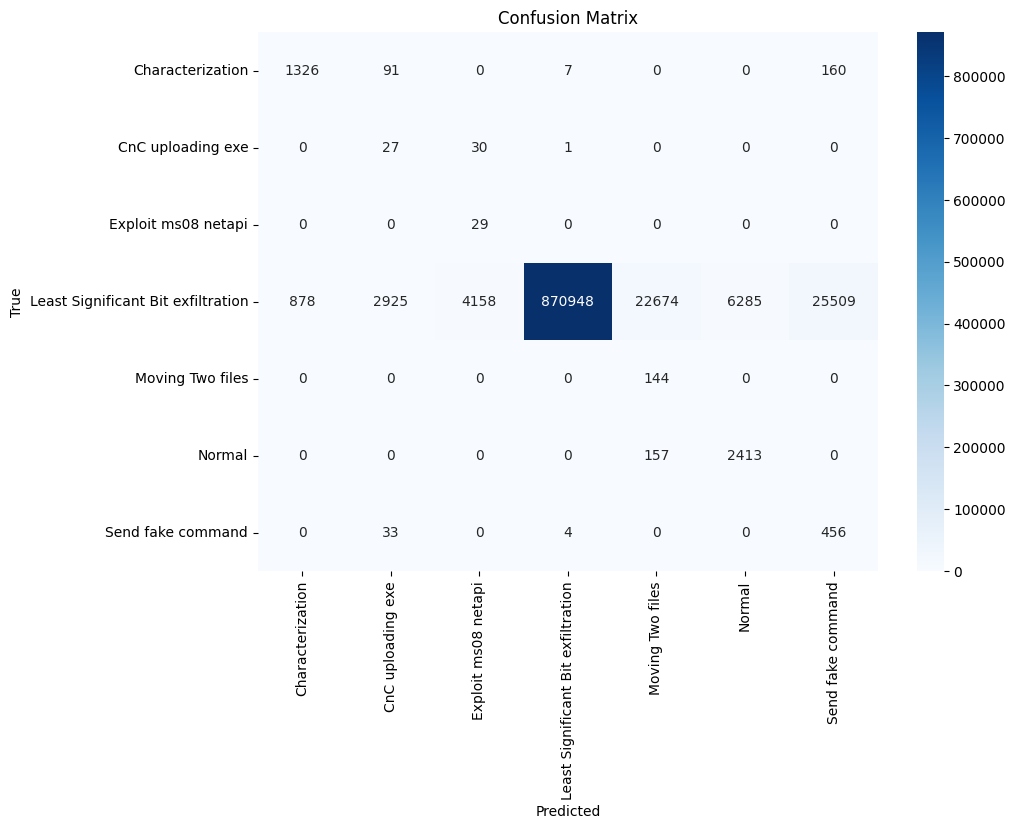

In [18]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_pred_probs = model.predict(X_test_cnn)  # Assuming X_test_cnn is defined
y_pred = np.argmax(y_pred_probs, axis=1)  # Get predicted class labels

# Calculate accuracy, precision, recall, f1-score
y_true = np.argmax(y_test_cat, axis=1)  # Assuming y_test_cat is one-hot encoded

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


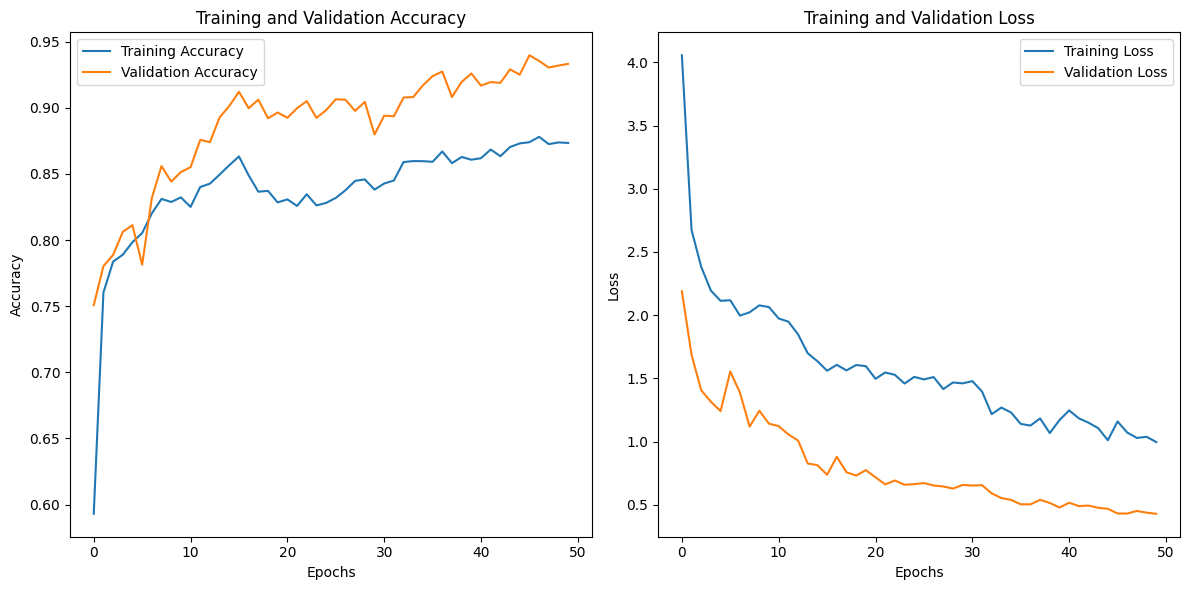

In [22]:
import matplotlib.pyplot as plt

# Assuming you have the 'history' object from training
# Plotting Training & Validation Accuracy
plt.figure(figsize=(12, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [19]:
model.save('IDS2_model.h5')


In [50]:
# from imblearn.over_sampling import SMOTE
# from collections import Counter

# # Check the current class distribution
# print("Original class distribution before SMOTE:", Counter(y_train))

# # Apply SMOTE only to the minority classes
# smote = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train)

# # Check new class distribution after SMOTE
# print("Class distribution after SMOTE:", Counter(y_train_resampled))

# # Reshape back to 3D for CNN input
# X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_cnn.shape[1], 1)

# # One-hot encode the labels
# y_train_resampled_cat = to_categorical(y_train_resampled, num_classes=7)

# print("One-hot encoded labels shape:", y_train_resampled_cat.shape)


Original class distribution before SMOTE: Counter({3: 2333439, 5: 10282, 0: 6335, 6: 1973, 4: 576, 1: 232, 2: 115})
Class distribution after SMOTE: Counter({3: 2333439, 5: 2333439, 1: 2333439, 6: 2333439, 0: 2333439, 2: 2333439, 4: 2333439})
One-hot encoded labels shape: (16334073, 7)
